In [448]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

from pedalboard.pedalboard import load_plugin

import numpy as np
import librosa

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

In [449]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Overdrive"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/ed5w27io/checkpoints/epoch=788-step=493125.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [450]:
if DAFX_NAME.lower() == "clean":
    dafx = NullDAFXWrapper()
else:
    dafx = load_plugin(DAFX_FILE, plugin_name=DAFX_NAME)
    dafx = DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [451]:
dataset = PairedAudioDataset(
    dafx=dafx,
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    length=131_072,
    effect_input=False,
    effect_output=True,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 16527.80it/s]


Loaded 88 files for train = 66.89 hours.


In [452]:
batch = next(iter(loader))
x, y = batch

In [453]:
x.shape

torch.Size([1, 1, 131072])

In [454]:
Audio(x.numpy().squeeze(), rate=SAMPLE_RATE)

In [455]:
# STFT condition
nFFT = 4096
winLen = 2048
shiftLen = 2048
window = torch.hann_window(winLen+2)[1:-1]
use_lib = True


def STFT(x):
    return torch.stft(x, n_fft=nFFT, win_length=winLen, hop_length=shiftLen, window=window, return_complex=True)

def STFT_lib(x):
    return librosa.core.stft(x, n_fft=nFFT, hop_length=shiftLen, win_length=winLen)

def iSTFT(x):
    return torch.istft(x, n_fft=nFFT, win_length=winLen, hop_length=shiftLen)

def iSTFT_lib(x):
    print(x.dtype)
    return librosa.core.istft(x, n_fft=nFFT, hop_length=shiftLen)

def stft_zero_padd(data):
    lf = len(data)
    T = int(np.ceil((lf - winLen) / shiftLen))
    lf_new = winLen + T * shiftLen
    data = np.concatenate([data, np.zeros(lf_new-lf,)])
    return data, lf_new

def mysign(x):
    return np.exp(1j * np.angle(x))

# GLA
def gla(z, amp, max_iter=100):
    for i in range(max_iter):
        x = amp * mysign(z)
        istft = iSTFT(x)
        z = STFT(istft)
    return x


# Proposed algorithm by Masuyama et al.
def admm_gla(z, u, amp, max_iter=100, rho=0.01):
    for i in range(max_iter):
        x = amp * mysign(z - u)
        v = x + u
        z = (rho * v + STFT(iSTFT(v))) / (1 + rho)
    return x


In [456]:
def normalise_spectrogram(X_db):
    X_db_norm = X_db

    # Normalise (0,1)
    X_db_norm -= 0.3352797
    X_db_norm /= 0.2745147

    return X_db_norm

In [458]:
def denormalise_spectrogram(X_db_norm):
    # Denormalise
    X_db = X_db_norm
    X_db *= 0.2745147
    X_db += 0.3352797

    return X_db

In [459]:
def audio_to_spectrogram(signal, use_lib=True):
    if use_lib:
        X = torch.tensor(STFT_lib(signal.squeeze().numpy()))
    else:
        X = STFT(signal.squeeze())

    # Absolute value part
    X_db = torch.pow(X.abs() + 1e-8, 0.3)
    X_db_norm = normalise_spectrogram(X_db)

    X_db_norm = X_db_norm.permute(1, 0)

    return X_db_norm

In [460]:
def spectrogram_to_audio(spectrogram, use_lib=True):
     # Undo permutation
    X_db_norm = spectrogram.clone().detach().permute(1, 0).squeeze()

    # Denormalise
    X_db = denormalise_spectrogram(X_db_norm)
    X_db = torch.pow(X_db, 3) - 1e-8

    spec_shape = X_db.shape
    z0 = X_db * np.exp(2 * np.pi * 1j * np.random.rand(spec_shape[0],
                                                       spec_shape[1]))
    u0 = np.zeros(X_db.shape)

    x_admm_gla = admm_gla(z0, u0, X_db)

    # # Masuyama et al.
    # datar_admm_gla = iSTFT(x_admm_gla)

    if use_lib:
        datar_admm_gla = iSTFT_lib(x_admm_gla.squeeze().numpy())
    else:
        datar_admm_gla = iSTFT(x_admm_gla.squeeze())

    return datar_admm_gla

In [461]:
x.shape

torch.Size([1, 1, 131072])

In [462]:
# data, lf = stft_zero_padd(x.squeeze())

In [463]:
X_pytorch = audio_to_spectrogram(x, use_lib=False)

In [464]:
X_librosa = audio_to_spectrogram(x, use_lib=True)

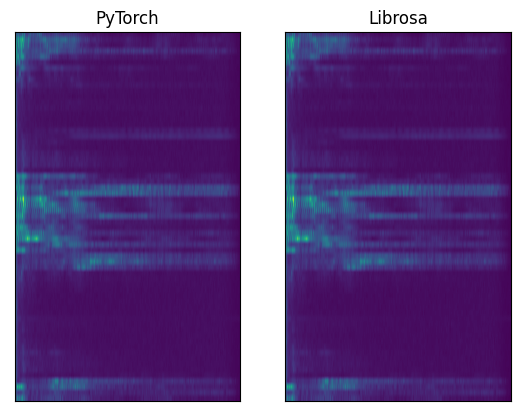

In [465]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(X_pytorch.squeeze(), aspect='auto')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("PyTorch")

ax[1].imshow(X_librosa.squeeze(), aspect='auto')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Librosa")

plt.show()

In [466]:
x_hat_pytorch = spectrogram_to_audio(X_pytorch, use_lib=False)

In [467]:
x_hat_librosa = spectrogram_to_audio(X_librosa, use_lib=True)

complex128


In [468]:
Audio(x.squeeze().numpy(), rate=SAMPLE_RATE)

In [469]:
Audio(x_hat_librosa, rate=SAMPLE_RATE)

In [470]:
Audio(x_hat_pytorch, rate=SAMPLE_RATE)